In [1]:
from argparse import Namespace
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

from vocabulary import Vocabulary

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

START_TOKEN = "^"
END_TOKEN = "_"

## Class Definitions 

Data Model:
- Raw data
- Vectorizer
- Vectorized Data
- Data generator

In [2]:
class RawSurnames(object):
    def __init__(self, data_path, delimiter=","):
        self.data = pd.read_csv(data_path, delimiter=delimiter)

    def get_data(self, filter_to_nationality=None):
        if filter_to_nationality is not None:
            return self.data[self.data.nationality.isin(filter_to_nationality)]
        return self.data

# vectorizer

class SurnamesVectorizer(object):
    def __init__(self, surname_vocab, nationality_vocab, max_seq_length):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self.max_seq_length = max_seq_length
        
    def save(self, filename):
        vec_dict = {"surname_vocab": self.surname_vocab.get_serializable_contents(),
                    "nationality_vocab": self.nationality_vocab.get_serializable_contents(),
                    'max_seq_length': self.max_seq_length}

        with open(filename, "w") as fp:
            json.dump(vec_dict, fp)
        
    @classmethod
    def load(cls, filename):
        with open(filename, "r") as fp:
            vec_dict = json.load(fp)

        vec_dict["surname_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["surname_vocab"])
        vec_dict["nationality_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["nationality_vocab"])
        return cls(**vec_dict)

    @classmethod
    def fit(cls, surname_df):
        """
        """
        surname_vocab = Vocabulary(use_unks=False,
                                   use_mask=True,
                                   use_start_end=True,
                                   start_token=START_TOKEN,
                                   end_token=END_TOKEN)

        nationality_vocab = Vocabulary(use_unks=False, use_start_end=False, use_mask=False)

        max_seq_length = 0
        for index, row in surname_df.iterrows():
            surname_vocab.add_many(row.surname)
            nationality_vocab.add(row.nationality)

            if len(row.surname) > max_seq_length:
                max_seq_length = len(row.surname)
        max_seq_length = max_seq_length + 2

        return cls(surname_vocab, nationality_vocab, max_seq_length)

    @classmethod
    def fit_transform(cls, surname_df, split='train'):
        vectorizer = cls.fit(surname_df)
        return vectorizer, vectorizer.transform(surname_df, split)

    def transform(self, surname_df, split='train'):

        df = surname_df[surname_df.split==split].reset_index()
        n_data = len(df)
        
        x_surnames = np.zeros((n_data, self.max_seq_length), dtype=np.int64)
        y_nationalities = np.zeros(n_data, dtype=np.int64)

        for index, row in df.iterrows():
            vectorized_surname = list(self.surname_vocab.map(row.surname, 
                                                             include_start_end=True))
            x_surnames[index, :len(vectorized_surname)] = vectorized_surname
            y_nationalities[index] = self.nationality_vocab[row.nationality]

        return VectorizedSurnames(x_surnames, y_nationalities)

# vec data


class VectorizedSurnames(Dataset):
    def __init__(self, x_surnames, y_nationalities):
        self.x_surnames = x_surnames
        self.y_nationalities = y_nationalities

    def __len__(self):
        return len(self.x_surnames)

    def __getitem__(self, index):
        return {'x_surnames': self.x_surnames[index],
                'y_nationalities': self.y_nationalities[index],
                'x_lengths': len(self.x_surnames[index].nonzero()[0])}

# data generator

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Class definitions for the model

In [5]:
def new_parameter(*size):
    out = torch.randn(*size, requires_grad=True, dtype=torch.float32)
    torch.nn.init.xavier_normal_(out)
    return nn.Parameter(out)

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class ExplicitRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False):
        super(ExplicitRNN, self).__init__()
        self.W_in2hid = new_parameter(input_size, hidden_size)
        self.W_hid2hid = new_parameter(hidden_size, hidden_size)
            
        self.b_hid = new_parameter(1, hidden_size)
        
        self.hidden_size = hidden_size

        self.batch_first = batch_first
    
    def _compute_next_hidden(self, x, h):
        return F.tanh(x.matmul(self.W_in2hid) + 
                      h.matmul(self.W_hid2hid) + 
                      self.b_hid)

    def forward(self, x_in, hid_t=None):
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()

        hiddens = []
        if hid_t is None:
            hid_t = torch.ones((batch_size, self.hidden_size))
        
        if x_in.is_cuda:
            hid_t = hid_t.cuda()
            
        for t in range(seq_size):
            x_t = x_in[t]
            hid_t = self._compute_next_hidden(x_t, hid_t)
            
            hiddens.append(hid_t)
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens
    
    
class CharNN(nn.Module):
    def __init__(self, embedding_size, in_vocab_size, out_vocab_size, hidden_size, 
                 batch_first=False):
        """
        Args:
            embedding_size (int): size of each embedding vector
            in_vocab_size (int): number of input characters
            out_vocab_size (int): number of characters to predict to
            hidden_size (int): the intermediate representation size
        """
        super(CharNN, self).__init__()
        
        self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=in_vocab_size, padding_idx=0)
        self.fc = nn.Linear(in_features=hidden_size, out_features=out_vocab_size)
        self.rnn = ExplicitRNN(input_size=embedding_size, hidden_size=hidden_size, 
                               batch_first=batch_first)
    
    
    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_in = self.emb(x_in)
        y_out = self.rnn(x_in)
        
        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :] 

        y_out = self.fc(y_out)

        if apply_softmax:
            y_out = F.softmax(y_out)
            
        return y_out

    
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

## Make, Train, and Eval

In [6]:
args = Namespace(
    surname_csv="../data/surnames.csv",
    batch_size = 128,
    cuda=False,
    learning_rate=0.001,
    num_epochs=100,
    load_zoo_model=True,
    zoo={
        'filename': '../modelzoo/charnn_emb16_hid64_surnames_classify.state',
        'vocab': '../modelzoo/surnames_classify.vocab',
        'comments': 'pre-trained surname classifier',
        'parameters': {
            'embedding_size': 16,
            'hidden_size': 64
        }
    }
)


# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")
args.device

Using CUDA: False


device(type='cpu')

In [7]:
# optional: set this to false to learn from scratch!
# args.load_zoo_model = False

In [8]:
raw_data = RawSurnames(args.surname_csv).get_data()

if os.path.exists(args.zoo['vocab']):
    vectorizer = SurnamesVectorizer.load(args.zoo['vocab'])
    print("Loading vectorizer!")
else:
    vectorizer = SurnamesVectorizer.fit(raw_data)
    print("Creating a new vectorizer.")
    
train_dataset = vectorizer.transform(raw_data, split='train')
test_dataset = vectorizer.transform(raw_data, split='test')

zoo_params = args.zoo['parameters']

net = CharNN(embedding_size=zoo_params['embedding_size'], 
             hidden_size=zoo_params['hidden_size'],
             in_vocab_size=len(vectorizer.surname_vocab), 
             out_vocab_size=len(vectorizer.nationality_vocab),
             batch_first=True)

if args.load_zoo_model and os.path.exists(args.zoo['filename']):
    print("Loading state dict!")
    net.load_state_dict(torch.load(args.zoo['filename'], 
                                   map_location=lambda storage, loc: storage))
else:
    print("Using newly initiated network!")

Loading vectorizer!
Loading state dict!


In [9]:
net = net.to(args.device)
    
# optimizer
    
optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)

# loss function / criterion with class-weighted modifications

class_counts = raw_data.nationality.value_counts().to_dict()
sorted_counts = sorted(class_counts.items(), key=lambda item: vectorizer.nationality_vocab[item[0]])
class_weights = 1.0 / torch.tensor([count for _, count in sorted_counts], dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# progress bars

epoch_bar = tqdm_notebook(desc='epochs', total=args.num_epochs, position=1)

num_train_batches = len(train_dataset) // args.batch_size
train_bar = tqdm_notebook(desc='training', total=num_train_batches, position=2)

num_test_batches = len(test_dataset) // args.batch_size
test_bar = tqdm_notebook(desc='test', total=num_test_batches, position=3)

# history 

train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

try:
    for _ in range(args.num_epochs):
        batch_generator = generate_batches(train_dataset, batch_size=args.batch_size,
                                           device=args.device)
        
        per_epoch_loss = []
        per_epoch_accuracy = []
        
        net.train()
            
        for batch_dict in batch_generator:
            # step 1
            optimizer.zero_grad()

            # step 2
            y_pred = net(batch_dict['x_surnames'], batch_dict['x_lengths'])
            y_target = batch_dict['y_nationalities']
            
            # step 3
            loss = criterion(y_pred, y_target)
  
            # step 4
            loss.backward()
            optimizer.step()
            
            # bonus steps: bookkeeping 
            
            per_epoch_loss.append(loss.item())
            accuracy = compute_accuracy(y_pred, y_target)
            per_epoch_accuracy.append(accuracy)

            train_bar.update()
            
            train_bar.set_postfix(loss=per_epoch_loss[-1], 
                                  accuracy=per_epoch_accuracy[-1])
            
        train_loss_history.append(np.mean(per_epoch_loss))
        train_accuracy_history.append(np.mean(per_epoch_accuracy))
        
        # loop over test dataset
        
        batch_generator = generate_batches(test_dataset, batch_size=args.batch_size, 
                                           device=args.device)
        
        per_epoch_loss = []
        per_epoch_accuracy = []
            
        # set it to eval mode; this turns stochastic functions off
        net.eval()
            
        for batch_dict in batch_generator:
            
            # step 1: compute output
            y_pred = net(batch_dict['x_surnames'], batch_dict['x_lengths'])
            y_target = batch_dict['y_nationalities'] 
            
            # step 2: compute whatever metrics; here we compute loss and accuracy
            
            loss = criterion(y_pred, y_target)
            per_epoch_loss.append(loss.item())
            accuracy = compute_accuracy(y_pred, y_target)
            per_epoch_accuracy.append(accuracy)

            test_bar.update()
            
            test_bar.set_postfix(loss=per_epoch_loss[-1], 
                                 accuracy=per_epoch_accuracy[-1])
            
        test_loss_history.append(np.mean(per_epoch_loss))
        test_accuracy_history.append(np.mean(per_epoch_accuracy))
        
        # update bars
        
        epoch_bar.set_postfix(train_loss=train_loss_history[-1], 
                              train_accuracy=train_accuracy_history[-1],
                              test_loss=test_loss_history[-1],
                              test_accuracy=test_accuracy_history[-1])
        epoch_bar.update()
        test_bar.n = 0
        train_bar.n = 0

except KeyboardInterrupt:
    print("...")

...


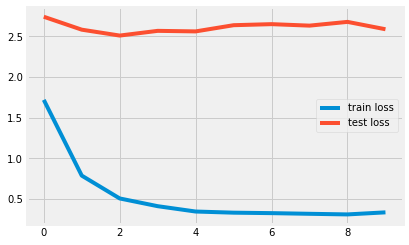

In [10]:
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.legend()

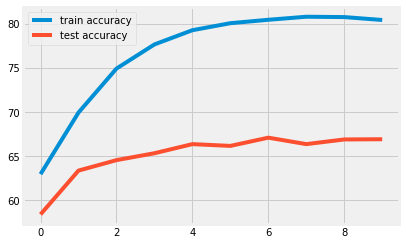

In [11]:
plt.plot(train_accuracy_history, label='train accuracy')
plt.plot(test_accuracy_history, label='test accuracy')
plt.legend()


In [12]:
def vectorize_surname(surname):
    surname_indices = list(vectorizer.surname_vocab.map(surname, include_start_end=True))
    surname_vector = torch.tensor(surname_indices, dtype=torch.int64).unsqueeze(dim=0)
    surname_length = torch.tensor([len(surname_indices)], dtype=torch.int64)
    return surname_vector, surname_length
    
def predict_nationality(net, surname):
    net = net.to("cpu")
    surname_vector, surname_length = vectorize_surname(surname)
    y_prediction = net(surname_vector, surname_length)
    _, nationality_index = y_prediction.max(dim=1)
    return vectorizer.nationality_vocab.lookup(nationality_index.item())

In [13]:
predict_nationality(net, 'satoshi nakamoto')

'japanese'

In [14]:
predict_nationality(net, 'mcmahan')

'irish'

In [15]:
predict_nationality(net, 'bismarck')

'dutch'

In [16]:
predict_nationality(net, 'anderson')

'scottish'